In [17]:
!pip install numpy pandas joblib matplotlib seaborn scikit-learn xgboost ta vnstock plotly statsmodels
!pip install lightgbm catboost optuna imbalanced-learn optuna



In [ ]:
import os
import pandas as pd

DATA_DIR = "data_vnstock"

for f in os.listdir(DATA_DIR):
    if not f.endswith(".csv"):
        continue

    path = os.path.join(DATA_DIR, f)

    try:
        df = pd.read_csv(path)
    except Exception as e:
        print("❌ File đọc lỗi:", f, e)
        continue

    df.columns = df.columns.str.strip().str.lower()

    required = ["time","open","high","low","close","volume"]
    missing = [c for c in required if c not in df.columns]

    if missing:
        print(f"❌ File lỗi: {f} — Thiếu cột: {missing} — Columns: {df.columns.tolist()}")


❌ File đọc lỗi: DPR.csv Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.


In [2]:
# Biến cố định
dictionary = "data_vnstock/"

In [25]:
# import thư viện
import os
from ta.trend import ADXIndicator
from ta.momentum import ROCIndicator
import time
import numpy as np
import pandas as pd
import joblib

import xgboost as xgb
from xgboost import XGBClassifier
from vnstock import Vnstock
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error,f1_score,accuracy_score
from sklearn.preprocessing import MinMaxScaler,LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import make_classification
# Thư viện vẽ biểu đồ
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import optuna
from statsmodels.tsa.seasonal import STL
from datetime import datetime

In [4]:
# khai báo object lấy từ nguồn TCBS/VCI
stockVN = Vnstock().stock(symbol='ACB', source='VCI')

# lấy ra danh sách các cổ phiếu
all_tickers = stockVN.listing.all_symbols()['symbol'].tolist()
print("Tổng số mã: {:d}".format(len(all_tickers)))

Tổng số mã: 1727


In [ ]:
os.makedirs("market", exist_ok=True)

# Lấy dữ liệu VNINDEX
vn = Vnstock().stock(symbol="VNINDEX", source="VCI")
end_date = datetime.today().strftime('%Y-%m-%d')

df_vn = vn.quote.history(start="2015-01-01", end=end_date)

# Kiểm tra và lưu file
if df_vn.empty:
    print("❌ Không lấy được dữ liệu VNINDEX")
else:
    df_vn.to_csv("market/VNINDEX.csv", index=False)
    print("✅ Đã lưu dữ liệu VNINDEX → market/VNINDEX.csv")
    print(df_vn.tail())

2025-11-14 23:38:22 - vnstock.common.data - INFO - Not a stock. Company and finance data unavailable.


✅ Đã lưu dữ liệu VNINDEX → market/VNINDEX.csv
           time     open     high      low    close     volume
2833 2025-11-10  1598.02  1609.49  1580.54  1580.54  733963463
2834 2025-11-11  1585.32  1597.08  1578.42  1593.61  664598578
2835 2025-11-12  1599.63  1631.86  1596.43  1631.86  757596568
2836 2025-11-13  1632.64  1638.98  1626.14  1631.44  699139664
2837 2025-11-14  1627.45  1638.35  1623.03  1635.46  703912296


In [ ]:
# tạo file
os.makedirs("data_vnstock", exist_ok=True)
request_count = 0
# Tải dữ liệu cổ phiếu và lưu CSV với delay giữa các request (10 request nghỉ 100s)
for ticker in all_tickers:
    try:
        stock = Vnstock().stock(symbol=ticker, source='VCI')
        end_date = datetime.today().strftime('%Y-%m-%d')
        df = stock.quote.history(start='2015-01-01', end=end_date)
        if not df.empty:
            df.to_csv(f"data_vnstock/{ticker}.csv", index=False)
            print(f"Lưu thành công: {ticker}")
        request_count += 1
        if request_count % 30 == 0:
            print("\n⏳ Nghỉ 30 giây sau 30 request...")
            time.sleep(30)
        else:
            time.sleep(0.8)
    except Exception as e:
        print(f"Lỗi với {ticker}: {e}")



Lưu thành công: YTC
Lưu thành công: YEG
Lưu thành công: YBM
Lưu thành công: YBC
Lưu thành công: XPH
Lưu thành công: XMP
Lưu thành công: XMD
Lưu thành công: XMC
Lưu thành công: XLV
Lưu thành công: XHC
Lưu thành công: XDH
Lưu thành công: XDC
Lưu thành công: X77
Lưu thành công: X26
Lưu thành công: X20
Lưu thành công: WTC
Lưu thành công: WSS
Lưu thành công: WSB
Lưu thành công: WCS
Lưu thành công: VXT
Lưu thành công: VXP
Lưu thành công: VXB
Lưu thành công: VWS
Lưu thành công: VW3
Lưu thành công: VVS
Lưu thành công: VVN
Lưu thành công: VUA
Lưu thành công: VTZ
Lưu thành công: VTX
Lưu thành công: VTV

⏳ Nghỉ 30 giây sau 30 request...


           time  open  high   low  close   volume
2563 2025-11-10  4.66  4.71  4.51   4.54  1513600
2564 2025-11-11  4.54  4.55  4.36   4.47  1665600
2565 2025-11-12  4.47  4.65  4.47   4.61   919400
2566 2025-11-13  4.61  4.70  4.51   4.51  1014500
2567 2025-11-14  4.51  4.70  4.51   4.51  1371100
776


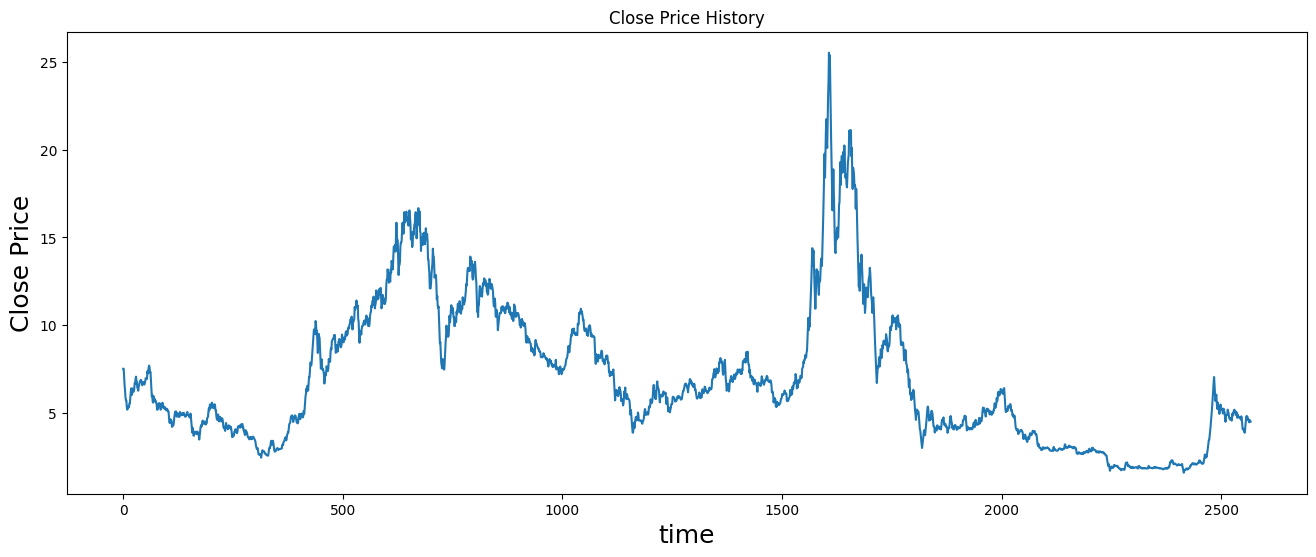

In [19]:
# test thử data 1 mã (Không thuộc luồng)
name = "LDG"

df = pd.read_csv(os.path.join(dictionary, name + '.csv'), sep=',')

df['time'] = pd.to_datetime(df['time'])
df.index = range(len(df))

print(df.tail())

for i in range(len(all_tickers)):
    if (name == all_tickers[i]):
        print(i)
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['close'])
plt.xlabel('time', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.show()


In [6]:
# dùng để tính rsi
def relative_strength_idx(df, n=14):
    close = df['close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

In [7]:
def filter_data(df):
    obtain = True
    if len(df) < 100:
        obtain = False
    
    last_date = df['time'].max().date()

    # 30 ngày cuối cùng tính theo last_date của dataset
    recent_30d = last_date - pd.to_timedelta(30, unit='d')

    recent_dates = df['time'].dt.date.unique()
    active_days_last_30 = [d for d in recent_dates if d >= recent_30d]
    if len(active_days_last_30) < 10:
        obtain = False

    if df['volume'].tail(20).mean() < 100000:
        obtain = False

    last_20_volume = df['volume'].tail(20)
    if (last_20_volume > 0).sum() < 15:
        obtain = False
        
    return obtain


In [9]:
def feature_adx_roc(df):
    df = df.copy()
    
    # Tính ADX
    adx = ADXIndicator(high=df['high'], low=df['low'], close=df['close'], window=14)
    df['adx'] = adx.adx()

    # Tính ROC (Rate of Change)
    roc = ROCIndicator(close=df['close'], window=10)
    df['roc'] = roc.roc()

    return df

In [10]:
def scale_features(df_temp, feature):
    df_temp = df_temp.copy()
    scaler = StandardScaler()
    df_temp[feature] = scaler.fit_transform(df_temp[feature])
    return df_temp, scaler

In [11]:
# các hàm xử lí (Mô hình xgboost dự đoán xu hướng cổ phiếu)
def create_labels(df, horizon=30, threshold=0.08):
    df = df.copy()
    df['future_price'] = df['close'].shift(-horizon)/df['close'] - 1
    df['label_price'] = (df['future_price'] >= threshold).astype(int)
    return df

In [12]:
def create_feature_data(df): 
    horizon = 30
    df['ema_9'] = df['close'].ewm(9).mean().shift(horizon)
    df['sma_5'] = df['close'].rolling(5).mean().shift(horizon)
    df['sma_10'] = df['close'].rolling(10).mean().shift(horizon)
    df['sma_15'] = df['close'].rolling(15).mean().shift(horizon)
    df['sma_30'] = df['close'].rolling(30).mean().shift(horizon)
    df['rsi'] = relative_strength_idx(df).fillna(0)
    ema_12 = pd.Series(df['close'].ewm(span=12, min_periods=12).mean())
    ema_26 = pd.Series(df['close'].ewm(span=26, min_periods=26).mean())
    df['macd'] = pd.Series(ema_12 - ema_26)
    df['macd_signal'] = pd.Series(df.macd.ewm(span=9, min_periods=9).mean())
    
    df_temp = feature_adx_roc(df)
    df_scaled, scaler = scale_features(df_temp, ['adx', 'roc'])
    
    # Gán các cột đã chuẩn hóa vào df gốc
    df['adx'] = df_scaled['adx']
    df['roc'] = df_scaled['roc']
    df['close'] = df['close'].shift(-horizon)
    return df

In [13]:
def data_split_train(df):
    test_size  = 0.15
    valid_size = 0.15

    test_split_idx  = int(df.shape[0] * (1-test_size))
    valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

    train_df  = df.loc[:valid_split_idx].copy()
    valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
    test_df   = df.loc[test_split_idx+1:].copy()
    
    drop_cols = ["time","high", "low","close", "open"]

    train_df = train_df.drop(drop_cols, axis=1)
    valid_df = valid_df.drop(drop_cols, axis=1)
    test_df  = test_df.drop(drop_cols, axis=1)
    
    y_train = train_df['label_price'].copy()
    X_train = train_df.drop(['label_price'], axis=1)

    y_valid = valid_df['label_price'].copy()
    X_valid = valid_df.drop(['label_price'], axis=1)

    y_test  = test_df['label_price'].copy()
    X_test  = test_df.drop(['label_price'], axis=1)
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test
    
    

In [14]:
X, y, X_valids,y_valids,X_tests, y_tests = [], [], [], [], [], []
qualified_tickers = []
features = [
    "trend",
    "volume", "ema_9", "sma_5", "sma_10", "rsi", "macd", "macd_signal", 
    "ticker_encoded","adx","roc"
]
ticker_data_cache = {}
le = LabelEncoder()
ticker_tests = []
all_tickers = [f.replace('.csv', '') for f in os.listdir("data_vnstock") if f.endswith(".csv")]
ticker_to_id = {ticker: idx for idx, ticker in enumerate(all_tickers)}

for t, ticker in enumerate(all_tickers):
    # print(all_tickers[t])
    filePath = os.path.join(dictionary, f"{ticker}.csv")
    # print(filePath) -> ex:  data_vnstock/YTC.csv
    
    # data từng mã cổ phiếu
    df = pd.read_csv(filePath, sep=',')
    
    df['close'] = df.apply(
    lambda row: (row['open'] + row['high'] + row['low']) / 3 if row['close'] == 0.0 else row['close'],
    axis=1
)
    df['ticker_encoded'] = t
    
    df['time'] = pd.to_datetime(df['time'])
    if df.empty:
        continue
    
    # bỏ những cổ phiếu không chất lượng
    if (filter_data(df) == False):
        continue
    
    df_close = df[['time', 'close']].copy()
    df_close = df_close.set_index('time')
    df_close.tail()
    
    # Phân rã bằng STL (modern)
    stl = STL(df_close['close'], period=50)
    res = stl.fit()
    
    df["trend"] = res.trend.values
    df['trend'] = (df['trend'].diff().shift(-1) > 0).astype(int)
    
    df = create_labels(df)
    df = create_feature_data(df)
    df = df.iloc[62:] # Because of moving averages and MACD line
    df = df[:-30]
    print(df)
    X_train, y_train, X_valid, y_valid, X_test, y_test = data_split_train(df)
    # print(X_train[features].values)
    # X_train.info()
    # df_inf = df[np.isinf(df.select_dtypes(include=[np.number])).any(axis=1)]
    # print("Các dòng chứa inf hoặc -inf:")
    # print(df_inf)
    numeric_df = df.select_dtypes(include=[np.number])
    if df.isnull().values.any() or df.isna().values.any() or np.isinf(numeric_df.values).any():
        print(f"Mã {ticker} có NaN hoặc inf")
    
    n_test = X_test.shape[0]
    ticker_tests.append(
        np.full(shape=n_test, fill_value=t, dtype=int)
    )
    
    X.append(X_train[features].values)
    y.append(y_train.values)
    X_tests.append(X_test[features].values)
    y_tests.append(y_test.values)
    X_valids.append(X_valid[features].values)
    y_valids.append(y_valid.values)
    # print(df['label_price'].values)
    # print(df[features].values)
    qualified_tickers.append(ticker)
    
    

    # # Vẽ biểu đồ như stldecompose
    # fig, axes = plt.subplots(4, 1, figsize=(20, 8), sharex=True)
    # axes[1].plot(res.trend, label='Trend')
    # axes[1].set_ylabel('Trend')
    # print(res.trend.tail(10), "head - trend")
    # print(df_close.tail(10))
    # ticker_data_cache[ticker] = df_feat

X = np.vstack(X)
y = np.hstack(y)
# print(X , y)
X_tests = np.vstack(X_tests)
y_tests = np.hstack(y_tests)
X_valids = np.vstack(X_valids)
y_valids = np.hstack(y_valids)
ticker_test_all = np.hstack(ticker_tests)
    
    

           time  open  high   low  close   volume  ticker_encoded  trend  \
62   2014-10-01  6.23  6.31  6.11   6.27   291300               1      0   
63   2014-10-02  6.27  6.50  6.27   6.27   438800               1      0   
64   2014-10-03  6.39  6.58  6.39   6.15   480600               1      0   
65   2014-10-06  6.50  6.58  6.46   6.15   210700               1      0   
66   2014-10-07  6.46  6.50  6.35   6.23   695400               1      0   
...         ...   ...   ...   ...    ...      ...             ...    ...   
2803 2025-09-29  8.62  8.62  8.35   7.80  2455300               1      0   
2804 2025-09-30  8.45  8.45  8.14   7.91  3446700               1      0   
2805 2025-10-01  8.25  8.38  8.19   8.02  1208200               1      0   
2806 2025-10-02  8.38  8.44  8.13   7.96  1838500               1      0   
2807 2025-10-03  8.17  8.21  8.08   7.90  1722900               1      0   

      future_price  label_price     ema_9  sma_5  sma_10    sma_15    sma_30  \
62     

In [15]:
print((y == 0).sum() / (y == 1).sum(), (y == 0).sum(),(y == 1).sum())

2.531244818960981 351152 138727


In [ ]:
# os.makedirs("models", exist_ok=True)
# # train mô hình xgboost
# scale_pos_weight = (y == 0).sum() / (y == 1).sum()
# # parameters = {
# #     'n_estimators': [100, 200, 300, 400,500],
# #     'learning_rate': [0.001, 0.005, 0.01, 0.05],
# #     'max_depth': [8, 10, 12, 15],
# #     'gamma': [0.001, 0.005, 0.01, 0.02],
# #     'random_state': [42],
#     # 'n_estimators': [100, 200, 300, 400, 500],
#     # 'learning_rate': [0.001, 0.003, 0.005, 0.007, 0.01],
#     # 'max_depth': [6, 8, 10, 12, 15],
#     # 'gamma': [0, 0.001, 0.005, 0.01, 0.02],
#     # 'subsample': [0.7, 0.8, 0.9, 1.0],
#     # 'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
#     # 'reg_alpha': [0, 0.01, 0.1],      
#     # 'reg_lambda': [1, 1.5, 2],       
#     # 'random_state': [42],
    
# # }

# parameters = {
#     'n_estimators': [400, 600, 800, 1000],
#     'learning_rate': [0.008, 0.01, 0.02, 0.03],
#     'max_depth': [6, 8, 10],
#     'min_child_weight': [2, 3, 4],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.7, 0.8, 0.9],
#     'gamma': [0.0, 0.01],
#     'reg_lambda': [1, 2, 3],
#     'reg_alpha': [0, 0.1],
# }

# eval_set = [ (X_valids, y_valids)]
# model = xgb.XGBClassifier(objective='binary:logistic',eval_metric='logloss',early_stopping_rounds=30,scale_pos_weight=scale_pos_weight)
# clf = GridSearchCV(model, parameters, cv=5, scoring='f1')

# clf.fit(X, y,eval_set=eval_set,verbose=False)
# joblib.dump(clf.best_estimator_, "models/best_xgb_model.pkl")
# print(f'Best params: {clf.best_params_}')
# print(f'Best validation score = {clf.best_score_}')
import optuna
import xgboost as xgb
import joblib
import os
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

os.makedirs("models", exist_ok=True)

# Tính scale_pos_weight
scale_pos_weight = (y == 0).sum() / (y == 1).sum()

# Tạo eval_set
eval_set = [(X_valids, y_valids)]

def objective(trial):
    # Định nghĩa không gian tìm kiếm (giống với GridSearch của bạn)
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [400, 600, 800, 1000]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008, 0.01, 0.02, 0.03]),
        'max_depth': trial.suggest_categorical('max_depth', [6, 8, 10]),
        'min_child_weight': trial.suggest_categorical('min_child_weight', [2, 3, 4]),
        'subsample': trial.suggest_categorical('subsample', [0.8, 0.9, 1.0]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.7, 0.8, 0.9]),
        'gamma': trial.suggest_categorical('gamma', [0.0, 0.01]),
        'reg_lambda': trial.suggest_categorical('reg_lambda', [1, 2, 3]),
        'reg_alpha': trial.suggest_categorical('reg_alpha', [0, 0.1]),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'scale_pos_weight': scale_pos_weight,
        'random_state': 42
    }
    
    # Tạo model
    model = xgb.XGBClassifier(**params)
    scores = cross_val_score(model, X, y, cv=5, scoring='f1', n_jobs=-1)
    
    return scores.mean()

# Tạo study và tối ưu hóa
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)

# Chạy optimization
print("Bắt đầu tối ưu hóa với Optuna...")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print(f'\n{"="*60}')
print(f'Best trial: {study.best_trial.number}')
print(f'Best F1 score (CV): {study.best_value:.4f}')
print(f'Best params: {study.best_params}')
print(f'{"="*60}\n')

# Train model cuối cùng với best params trên toàn bộ training data
best_params = study.best_params.copy()
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': scale_pos_weight,
    'random_state': 42
})

print("Training model cuối cùng với best params...")
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(
    X, y, 
    eval_set=eval_set, 
    verbose=False
)

# Lưu model
joblib.dump(best_model, "models/best_xgb_model.pkl")
print("✓ Model đã được lưu tại: models/best_xgb_model.pkl")

# Đánh giá trên validation set
y_pred = best_model.predict(X_valids)
val_f1 = f1_score(y_valids, y_pred)
print(f"F1 Score trên validation set: {val_f1:.4f}")

[I 2025-11-24 20:25:37,133] A new study created in memory with name: no-name-5c5f8c83-eebb-4cff-8d0d-0c3316aaa27a


Bắt đầu tối ưu hóa với Optuna...


Best trial: 0. Best value: 0.404202:   1%|          | 1/100 [00:58<1:36:56, 58.75s/it]

[I 2025-11-24 20:26:35,885] Trial 0 finished with value: 0.4042022125724002 and parameters: {'n_estimators': 600, 'learning_rate': 0.03, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 1.0, 'colsample_bytree': 0.7, 'gamma': 0.0, 'reg_lambda': 3, 'reg_alpha': 0}. Best is trial 0 with value: 0.4042022125724002.


Best trial: 0. Best value: 0.404202:   2%|▏         | 2/100 [02:12<1:50:27, 67.63s/it]

[I 2025-11-24 20:27:49,727] Trial 1 finished with value: 0.38608986597152056 and parameters: {'n_estimators': 1000, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 0.01, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 0 with value: 0.4042022125724002.


Best trial: 2. Best value: 0.438297:   3%|▎         | 3/100 [03:07<1:39:52, 61.77s/it]

[I 2025-11-24 20:28:44,541] Trial 2 finished with value: 0.4382972026857641 and parameters: {'n_estimators': 600, 'learning_rate': 0.02, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.01, 'reg_lambda': 1, 'reg_alpha': 0.1}. Best is trial 2 with value: 0.4382972026857641.


Best trial: 2. Best value: 0.438297:   4%|▍         | 4/100 [04:05<1:36:46, 60.48s/it]

[I 2025-11-24 20:29:43,029] Trial 3 finished with value: 0.4199869710685302 and parameters: {'n_estimators': 400, 'learning_rate': 0.03, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.9, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0.1}. Best is trial 2 with value: 0.4382972026857641.


Best trial: 4. Best value: 0.464999:   5%|▌         | 5/100 [06:11<2:12:59, 83.99s/it]

[I 2025-11-24 20:31:48,708] Trial 4 finished with value: 0.464998625280525 and parameters: {'n_estimators': 800, 'learning_rate': 0.008, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 0.01, 'reg_lambda': 1, 'reg_alpha': 0.1}. Best is trial 4 with value: 0.464998625280525.


Best trial: 5. Best value: 0.480166:   6%|▌         | 6/100 [07:21<2:04:16, 79.33s/it]

[I 2025-11-24 20:32:58,982] Trial 5 finished with value: 0.48016573695940784 and parameters: {'n_estimators': 800, 'learning_rate': 0.008, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.01, 'reg_lambda': 1, 'reg_alpha': 0.1}. Best is trial 5 with value: 0.48016573695940784.


Best trial: 5. Best value: 0.480166:   7%|▋         | 7/100 [08:25<1:55:12, 74.33s/it]

[I 2025-11-24 20:34:03,014] Trial 6 finished with value: 0.38758923441490345 and parameters: {'n_estimators': 1000, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 3, 'reg_alpha': 0}. Best is trial 5 with value: 0.48016573695940784.


Best trial: 5. Best value: 0.480166:   8%|▊         | 8/100 [09:59<2:03:10, 80.33s/it]

[I 2025-11-24 20:35:36,216] Trial 7 finished with value: 0.39005548456099914 and parameters: {'n_estimators': 1000, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.01, 'reg_lambda': 1, 'reg_alpha': 0}. Best is trial 5 with value: 0.48016573695940784.


Best trial: 5. Best value: 0.480166:   9%|▉         | 9/100 [12:53<2:46:38, 109.88s/it]

[I 2025-11-24 20:38:31,056] Trial 8 finished with value: 0.44535783738883755 and parameters: {'n_estimators': 1000, 'learning_rate': 0.008, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 3, 'reg_alpha': 0}. Best is trial 5 with value: 0.48016573695940784.


Best trial: 5. Best value: 0.480166:  10%|█         | 10/100 [14:38<2:42:23, 108.26s/it]

[I 2025-11-24 20:40:15,682] Trial 9 finished with value: 0.4715860504907239 and parameters: {'n_estimators': 800, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.01, 'reg_lambda': 1, 'reg_alpha': 0}. Best is trial 5 with value: 0.48016573695940784.


Best trial: 5. Best value: 0.480166:  11%|█         | 11/100 [15:57<2:27:27, 99.42s/it] 

[I 2025-11-24 20:41:35,044] Trial 10 finished with value: 0.46220801833877745 and parameters: {'n_estimators': 800, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.9, 'colsample_bytree': 0.7, 'gamma': 0.01, 'reg_lambda': 1, 'reg_alpha': 0.1}. Best is trial 5 with value: 0.48016573695940784.


Best trial: 5. Best value: 0.480166:  12%|█▏        | 12/100 [17:36<2:25:34, 99.25s/it]

[I 2025-11-24 20:43:13,934] Trial 11 finished with value: 0.46869377431840276 and parameters: {'n_estimators': 800, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.01, 'reg_lambda': 1, 'reg_alpha': 0.1}. Best is trial 5 with value: 0.48016573695940784.


Best trial: 5. Best value: 0.480166:  13%|█▎        | 13/100 [19:11<2:21:52, 97.85s/it]

[I 2025-11-24 20:44:48,545] Trial 12 finished with value: 0.47206119728583407 and parameters: {'n_estimators': 800, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.01, 'reg_lambda': 1, 'reg_alpha': 0.1}. Best is trial 5 with value: 0.48016573695940784.


Best trial: 5. Best value: 0.480166:  14%|█▍        | 14/100 [20:47<2:19:31, 97.34s/it]

[I 2025-11-24 20:46:24,709] Trial 13 finished with value: 0.47051660752796964 and parameters: {'n_estimators': 800, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 0.01, 'reg_lambda': 1, 'reg_alpha': 0.1}. Best is trial 5 with value: 0.48016573695940784.


Best trial: 5. Best value: 0.480166:  15%|█▌        | 15/100 [21:35<1:56:40, 82.36s/it]

[I 2025-11-24 20:47:12,350] Trial 14 finished with value: 0.446879670331379 and parameters: {'n_estimators': 400, 'learning_rate': 0.02, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.9, 'colsample_bytree': 0.7, 'gamma': 0.01, 'reg_lambda': 1, 'reg_alpha': 0.1}. Best is trial 5 with value: 0.48016573695940784.


Best trial: 5. Best value: 0.480166:  16%|█▌        | 16/100 [22:49<1:51:51, 79.90s/it]

[I 2025-11-24 20:48:26,532] Trial 15 finished with value: 0.4633477581242794 and parameters: {'n_estimators': 800, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.01, 'reg_lambda': 2, 'reg_alpha': 0.1}. Best is trial 5 with value: 0.48016573695940784.


Best trial: 5. Best value: 0.480166:  17%|█▋        | 17/100 [24:39<2:02:53, 88.84s/it]

[I 2025-11-24 20:50:16,158] Trial 16 finished with value: 0.46972235051730715 and parameters: {'n_estimators': 800, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.01, 'reg_lambda': 1, 'reg_alpha': 0.1}. Best is trial 5 with value: 0.48016573695940784.


Best trial: 17. Best value: 0.483001:  18%|█▊        | 18/100 [26:05<2:00:32, 88.20s/it]

[I 2025-11-24 20:51:42,875] Trial 17 finished with value: 0.48300097912737855 and parameters: {'n_estimators': 800, 'learning_rate': 0.008, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.01, 'reg_lambda': 1, 'reg_alpha': 0.1}. Best is trial 17 with value: 0.48300097912737855.


Best trial: 18. Best value: 0.524326:  19%|█▉        | 19/100 [27:08<1:48:37, 80.47s/it]

[I 2025-11-24 20:52:45,329] Trial 18 finished with value: 0.5243262351157915 and parameters: {'n_estimators': 600, 'learning_rate': 0.008, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 3, 'reg_alpha': 0.1}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 18. Best value: 0.524326:  20%|██        | 20/100 [28:05<1:38:12, 73.66s/it]

[I 2025-11-24 20:53:43,110] Trial 19 finished with value: 0.49504823891780053 and parameters: {'n_estimators': 600, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 3, 'reg_alpha': 0.1}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 18. Best value: 0.524326:  21%|██        | 21/100 [29:00<1:29:20, 67.85s/it]

[I 2025-11-24 20:54:37,429] Trial 20 finished with value: 0.49504823891780053 and parameters: {'n_estimators': 600, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 3, 'reg_alpha': 0.1}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 18. Best value: 0.524326:  22%|██▏       | 22/100 [30:05<1:27:00, 66.93s/it]

[I 2025-11-24 20:55:42,204] Trial 21 finished with value: 0.49504823891780053 and parameters: {'n_estimators': 600, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 3, 'reg_alpha': 0.1}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 18. Best value: 0.524326:  23%|██▎       | 23/100 [31:10<1:25:11, 66.39s/it]

[I 2025-11-24 20:56:47,325] Trial 22 finished with value: 0.49504823891780053 and parameters: {'n_estimators': 600, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 3, 'reg_alpha': 0.1}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 18. Best value: 0.524326:  24%|██▍       | 24/100 [32:13<1:22:47, 65.36s/it]

[I 2025-11-24 20:57:50,296] Trial 23 finished with value: 0.49504823891780053 and parameters: {'n_estimators': 600, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 3, 'reg_alpha': 0.1}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 18. Best value: 0.524326:  25%|██▌       | 25/100 [33:13<1:19:51, 63.88s/it]

[I 2025-11-24 20:58:50,728] Trial 24 finished with value: 0.49504823891780053 and parameters: {'n_estimators': 600, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 3, 'reg_alpha': 0.1}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 18. Best value: 0.524326:  26%|██▌       | 26/100 [34:18<1:19:03, 64.10s/it]

[I 2025-11-24 20:59:55,336] Trial 25 finished with value: 0.49504823891780053 and parameters: {'n_estimators': 600, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 3, 'reg_alpha': 0.1}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 18. Best value: 0.524326:  27%|██▋       | 27/100 [35:55<1:30:00, 73.98s/it]

[I 2025-11-24 21:01:32,369] Trial 26 finished with value: 0.4619409243694575 and parameters: {'n_estimators': 600, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 1.0, 'colsample_bytree': 0.7, 'gamma': 0.0, 'reg_lambda': 3, 'reg_alpha': 0.1}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 18. Best value: 0.524326:  28%|██▊       | 28/100 [36:50<1:21:58, 68.32s/it]

[I 2025-11-24 21:02:27,470] Trial 27 finished with value: 0.43987079796283746 and parameters: {'n_estimators': 600, 'learning_rate': 0.02, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 3, 'reg_alpha': 0.1}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 18. Best value: 0.524326:  29%|██▉       | 29/100 [37:52<1:18:43, 66.53s/it]

[I 2025-11-24 21:03:29,813] Trial 28 finished with value: 0.49504823891780053 and parameters: {'n_estimators': 600, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 3, 'reg_alpha': 0.1}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 18. Best value: 0.524326:  30%|███       | 30/100 [38:37<1:09:58, 59.98s/it]

[I 2025-11-24 21:04:14,533] Trial 29 finished with value: 0.48982179432572587 and parameters: {'n_estimators': 600, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 1.0, 'colsample_bytree': 0.7, 'gamma': 0.0, 'reg_lambda': 3, 'reg_alpha': 0}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 18. Best value: 0.524326:  31%|███       | 31/100 [39:42<1:10:37, 61.41s/it]

[I 2025-11-24 21:05:19,279] Trial 30 finished with value: 0.4481025424055143 and parameters: {'n_estimators': 400, 'learning_rate': 0.02, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 3, 'reg_alpha': 0.1}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 18. Best value: 0.524326:  32%|███▏      | 32/100 [40:34<1:06:26, 58.62s/it]

[I 2025-11-24 21:06:11,406] Trial 31 finished with value: 0.49504823891780053 and parameters: {'n_estimators': 600, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 3, 'reg_alpha': 0.1}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 18. Best value: 0.524326:  33%|███▎      | 33/100 [41:32<1:05:16, 58.45s/it]

[I 2025-11-24 21:07:09,459] Trial 32 finished with value: 0.49504823891780053 and parameters: {'n_estimators': 600, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 3, 'reg_alpha': 0.1}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 18. Best value: 0.524326:  34%|███▍      | 34/100 [42:32<1:04:55, 59.02s/it]

[I 2025-11-24 21:08:09,783] Trial 33 finished with value: 0.49504823891780053 and parameters: {'n_estimators': 600, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 3, 'reg_alpha': 0.1}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 18. Best value: 0.524326:  35%|███▌      | 35/100 [43:21<1:00:32, 55.89s/it]

[I 2025-11-24 21:08:58,382] Trial 34 finished with value: 0.48979507543512113 and parameters: {'n_estimators': 600, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 1.0, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0.1}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 18. Best value: 0.524326:  36%|███▌      | 36/100 [44:18<1:00:08, 56.38s/it]

[I 2025-11-24 21:09:55,895] Trial 35 finished with value: 0.41557387161905696 and parameters: {'n_estimators': 600, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 3, 'reg_alpha': 0.1}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 18. Best value: 0.524326:  37%|███▋      | 37/100 [45:22<1:01:25, 58.49s/it]

[I 2025-11-24 21:10:59,319] Trial 36 finished with value: 0.49162783317048636 and parameters: {'n_estimators': 600, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 18. Best value: 0.524326:  38%|███▊      | 38/100 [46:02<54:47, 53.03s/it]  

[I 2025-11-24 21:11:39,610] Trial 37 finished with value: 0.4679309891398643 and parameters: {'n_estimators': 400, 'learning_rate': 0.02, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 3, 'reg_alpha': 0.1}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 18. Best value: 0.524326:  39%|███▉      | 39/100 [47:33<1:05:22, 64.30s/it]

[I 2025-11-24 21:13:10,196] Trial 38 finished with value: 0.39757932817477704 and parameters: {'n_estimators': 600, 'learning_rate': 0.03, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.9, 'colsample_bytree': 0.7, 'gamma': 0.0, 'reg_lambda': 3, 'reg_alpha': 0.1}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 18. Best value: 0.524326:  40%|████      | 40/100 [48:39<1:05:02, 65.05s/it]

[I 2025-11-24 21:14:16,984] Trial 39 finished with value: 0.4575281311759351 and parameters: {'n_estimators': 1000, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 1.0, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 3, 'reg_alpha': 0}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 18. Best value: 0.524326:  41%|████      | 41/100 [49:36<1:01:29, 62.54s/it]

[I 2025-11-24 21:15:13,674] Trial 40 finished with value: 0.49621112124337996 and parameters: {'n_estimators': 600, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0.1}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 18. Best value: 0.524326:  42%|████▏     | 42/100 [50:38<1:00:10, 62.24s/it]

[I 2025-11-24 21:16:15,233] Trial 41 finished with value: 0.49621112124337996 and parameters: {'n_estimators': 600, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0.1}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 18. Best value: 0.524326:  43%|████▎     | 43/100 [51:40<59:06, 62.23s/it]  

[I 2025-11-24 21:17:17,428] Trial 42 finished with value: 0.49621112124337996 and parameters: {'n_estimators': 600, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0.1}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 18. Best value: 0.524326:  44%|████▍     | 44/100 [52:43<58:24, 62.58s/it]

[I 2025-11-24 21:18:20,806] Trial 43 finished with value: 0.49621112124337996 and parameters: {'n_estimators': 600, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0.1}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 18. Best value: 0.524326:  45%|████▌     | 45/100 [54:22<1:07:15, 73.37s/it]

[I 2025-11-24 21:19:59,376] Trial 44 finished with value: 0.46550962567400606 and parameters: {'n_estimators': 1000, 'learning_rate': 0.008, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.9, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0.1}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 18. Best value: 0.524326:  46%|████▌     | 46/100 [55:19<1:01:43, 68.59s/it]

[I 2025-11-24 21:20:56,803] Trial 45 finished with value: 0.4170199385278358 and parameters: {'n_estimators': 600, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0.1}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 18. Best value: 0.524326:  47%|████▋     | 47/100 [57:05<1:10:23, 79.68s/it]

[I 2025-11-24 21:22:42,380] Trial 46 finished with value: 0.4705479000141214 and parameters: {'n_estimators': 600, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 18 with value: 0.5243262351157915.


Best trial: 47. Best value: 0.554119:  48%|████▊     | 48/100 [57:49<59:44, 68.93s/it]  

[I 2025-11-24 21:23:26,211] Trial 47 finished with value: 0.5541194150139176 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0.1}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  49%|████▉     | 49/100 [58:32<52:10, 61.39s/it]

[I 2025-11-24 21:24:10,012] Trial 48 finished with value: 0.549899979187161 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0.1}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  50%|█████     | 50/100 [59:27<49:24, 59.28s/it]

[I 2025-11-24 21:25:04,381] Trial 49 finished with value: 0.5279687033785015 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0.1}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  51%|█████     | 51/100 [1:00:24<47:57, 58.72s/it]

[I 2025-11-24 21:26:01,765] Trial 50 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  52%|█████▏    | 52/100 [1:01:20<46:14, 57.81s/it]

[I 2025-11-24 21:26:57,470] Trial 51 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  53%|█████▎    | 53/100 [1:02:14<44:19, 56.59s/it]

[I 2025-11-24 21:27:51,224] Trial 52 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  54%|█████▍    | 54/100 [1:03:10<43:23, 56.60s/it]

[I 2025-11-24 21:28:47,837] Trial 53 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  55%|█████▌    | 55/100 [1:04:06<42:11, 56.26s/it]

[I 2025-11-24 21:29:43,296] Trial 54 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  56%|█████▌    | 56/100 [1:05:01<41:04, 56.01s/it]

[I 2025-11-24 21:30:38,712] Trial 55 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  57%|█████▋    | 57/100 [1:05:58<40:13, 56.14s/it]

[I 2025-11-24 21:31:35,153] Trial 56 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  58%|█████▊    | 58/100 [1:07:00<40:35, 57.99s/it]

[I 2025-11-24 21:32:37,465] Trial 57 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  59%|█████▉    | 59/100 [1:08:07<41:35, 60.87s/it]

[I 2025-11-24 21:33:45,073] Trial 58 finished with value: 0.5272443316723449 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.01, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  60%|██████    | 60/100 [1:09:10<40:53, 61.33s/it]

[I 2025-11-24 21:34:47,466] Trial 59 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  61%|██████    | 61/100 [1:10:08<39:18, 60.47s/it]

[I 2025-11-24 21:35:45,918] Trial 60 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  62%|██████▏   | 62/100 [1:11:06<37:47, 59.68s/it]

[I 2025-11-24 21:36:43,772] Trial 61 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  63%|██████▎   | 63/100 [1:12:05<36:33, 59.29s/it]

[I 2025-11-24 21:37:42,144] Trial 62 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  64%|██████▍   | 64/100 [1:12:58<34:31, 57.53s/it]

[I 2025-11-24 21:38:35,568] Trial 63 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  65%|██████▌   | 65/100 [1:13:43<31:25, 53.86s/it]

[I 2025-11-24 21:39:20,874] Trial 64 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  66%|██████▌   | 66/100 [1:14:38<30:43, 54.21s/it]

[I 2025-11-24 21:40:15,886] Trial 65 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  67%|██████▋   | 67/100 [1:15:40<30:59, 56.36s/it]

[I 2025-11-24 21:41:17,251] Trial 66 finished with value: 0.5272443316723449 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.01, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  68%|██████▊   | 68/100 [1:16:40<30:38, 57.47s/it]

[I 2025-11-24 21:42:17,311] Trial 67 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  69%|██████▉   | 69/100 [1:17:35<29:20, 56.79s/it]

[I 2025-11-24 21:43:12,518] Trial 68 finished with value: 0.5237221520953342 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  70%|███████   | 70/100 [1:18:36<29:02, 58.07s/it]

[I 2025-11-24 21:44:13,585] Trial 69 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  71%|███████   | 71/100 [1:19:35<28:14, 58.41s/it]

[I 2025-11-24 21:45:12,799] Trial 70 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  72%|███████▏  | 72/100 [1:20:36<27:39, 59.28s/it]

[I 2025-11-24 21:46:14,097] Trial 71 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  73%|███████▎  | 73/100 [1:21:33<26:20, 58.55s/it]

[I 2025-11-24 21:47:10,956] Trial 72 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  74%|███████▍  | 74/100 [1:22:29<24:57, 57.60s/it]

[I 2025-11-24 21:48:06,351] Trial 73 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  75%|███████▌  | 75/100 [1:23:23<23:35, 56.63s/it]

[I 2025-11-24 21:49:00,708] Trial 74 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  76%|███████▌  | 76/100 [1:24:19<22:36, 56.53s/it]

[I 2025-11-24 21:49:56,996] Trial 75 finished with value: 0.5265079170506942 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 1, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  77%|███████▋  | 77/100 [1:25:12<21:14, 55.42s/it]

[I 2025-11-24 21:50:49,830] Trial 76 finished with value: 0.5117509266517926 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.7, 'gamma': 0.01, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  78%|███████▊  | 78/100 [1:26:02<19:43, 53.78s/it]

[I 2025-11-24 21:51:39,802] Trial 77 finished with value: 0.44977201951192197 and parameters: {'n_estimators': 400, 'learning_rate': 0.02, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  79%|███████▉  | 79/100 [1:28:51<30:51, 88.15s/it]

[I 2025-11-24 21:54:28,147] Trial 78 finished with value: 0.4436376714823787 and parameters: {'n_estimators': 1000, 'learning_rate': 0.008, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  80%|████████  | 80/100 [1:29:44<25:56, 77.80s/it]

[I 2025-11-24 21:55:21,795] Trial 79 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  81%|████████  | 81/100 [1:31:25<26:49, 84.74s/it]

[I 2025-11-24 21:57:02,712] Trial 80 finished with value: 0.470502968451302 and parameters: {'n_estimators': 800, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 1, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  82%|████████▏ | 82/100 [1:32:16<22:21, 74.54s/it]

[I 2025-11-24 21:57:53,443] Trial 81 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  83%|████████▎ | 83/100 [1:33:03<18:49, 66.42s/it]

[I 2025-11-24 21:58:40,922] Trial 82 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  84%|████████▍ | 84/100 [1:34:10<17:45, 66.59s/it]

[I 2025-11-24 21:59:47,902] Trial 83 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


e:\Stock Project\.venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning:


2 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "e:\Stock Project\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "e:\Stock Project\.venv\lib\site-packages\xgboost\core.py", line 774, in inner_f
    return func(**kwargs)
  File "e:\Stock Project\.venv\lib\site-packages\xgboost\sklearn.py", line 1784, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "e:\Stock Project\.venv\lib\site-packages\xgboost\skl

[W 2025-11-24 22:00:37,948] Trial 84 failed with parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0} because of the following error: The value nan is not acceptable.
[W 2025-11-24 22:00:37,954] Trial 84 failed with value np.float64(nan).


Best trial: 47. Best value: 0.554119:  86%|████████▌ | 86/100 [1:35:42<12:57, 55.52s/it]

[I 2025-11-24 22:01:19,228] Trial 85 finished with value: 0.42196318581152986 and parameters: {'n_estimators': 400, 'learning_rate': 0.03, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  87%|████████▋ | 87/100 [1:36:51<12:56, 59.75s/it]

[I 2025-11-24 22:02:28,859] Trial 86 finished with value: 0.5117760951141868 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.7, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  88%|████████▊ | 88/100 [1:37:52<12:00, 60.06s/it]

[I 2025-11-24 22:03:29,641] Trial 87 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  89%|████████▉ | 89/100 [1:38:43<10:31, 57.42s/it]

[I 2025-11-24 22:04:20,913] Trial 88 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  90%|█████████ | 90/100 [1:39:44<09:43, 58.36s/it]

[I 2025-11-24 22:05:21,443] Trial 89 finished with value: 0.4434780937886411 and parameters: {'n_estimators': 400, 'learning_rate': 0.02, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.01, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  91%|█████████ | 91/100 [1:42:00<12:16, 81.82s/it]

[I 2025-11-24 22:07:38,012] Trial 90 finished with value: 0.44850331229031254 and parameters: {'n_estimators': 1000, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  92%|█████████▏| 92/100 [1:43:02<10:06, 75.76s/it]

[I 2025-11-24 22:08:39,642] Trial 91 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  93%|█████████▎| 93/100 [1:44:01<08:15, 70.76s/it]

[I 2025-11-24 22:09:38,716] Trial 92 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  94%|█████████▍| 94/100 [1:44:58<06:38, 66.46s/it]

[I 2025-11-24 22:10:35,137] Trial 93 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  95%|█████████▌| 95/100 [1:45:57<05:22, 64.46s/it]

[I 2025-11-24 22:11:34,920] Trial 94 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  96%|█████████▌| 96/100 [1:46:52<04:06, 61.53s/it]

[I 2025-11-24 22:12:29,638] Trial 95 finished with value: 0.5280020381842647 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  97%|█████████▋| 97/100 [1:47:38<02:50, 56.81s/it]

[I 2025-11-24 22:13:15,435] Trial 96 finished with value: 0.5273235484381198 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  98%|█████████▊| 98/100 [1:49:07<02:13, 66.51s/it]

[I 2025-11-24 22:14:44,569] Trial 97 finished with value: 0.39663153164027676 and parameters: {'n_estimators': 800, 'learning_rate': 0.03, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119:  99%|█████████▉| 99/100 [1:49:59<01:02, 62.20s/it]

[I 2025-11-24 22:15:36,728] Trial 98 finished with value: 0.5106911285313113 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.7, 'gamma': 0.0, 'reg_lambda': 1, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.


Best trial: 47. Best value: 0.554119: 100%|██████████| 100/100 [1:51:08<00:00, 66.68s/it]


[I 2025-11-24 22:16:45,563] Trial 99 finished with value: 0.5158095016570627 and parameters: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0}. Best is trial 47 with value: 0.5541194150139176.

Best trial: 47
Best F1 score (CV): 0.5541
Best params: {'n_estimators': 400, 'learning_rate': 0.008, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 2, 'reg_alpha': 0.1}

Training model cuối cùng với best params...
✓ Model đã được lưu tại: models/best_xgb_model.pkl
F1 Score trên validation set: 0.5911


In [ ]:
print(X_tests)

In [30]:
probas = best_model.predict_proba(X_tests)[:,1]

df_pred = pd.DataFrame({
    'ticker_encoded': ticker_test_all,
    'proba_increase': probas
})

print(df_pred.tail())

# Tính trung bình xác suất cho mỗi ticker
mean_proba = (df_pred
              .groupby('ticker_encoded')['proba_increase']
              .mean()
              .sort_values(ascending=False))

id_to_ticker = {v:k for k,v in ticker_to_id.items()}
mean_proba.index = mean_proba.index.map(id_to_ticker)
print("Mean proba after mapping:\n", mean_proba.head())


        ticker_encoded  proba_increase
128748            1689        0.036635
128749            1689        0.036982
128750            1689        0.036990
128751            1689        0.037243
128752            1689        0.040904
Mean proba after mapping:
 ticker_encoded
MZG    0.633966
TLD    0.628403
HAH    0.598603
HVN    0.590670
L40    0.589257
Name: proba_increase, dtype: float32


In [31]:
# Dự đoán nhãn trên tập test
y_pred = best_model.predict(X_tests)

# Tính độ chính xác (accuracy) và F1-score
acc = accuracy_score(y_tests, y_pred)
f1 = f1_score(y_tests, y_pred)

print(f"✅ Accuracy trên tập test: {acc:.4f} ({acc*100:.2f}%)")
print(f"✅ F1-score trên tập test: {f1:.4f}")

✅ Accuracy trên tập test: 0.6587 (65.87%)
✅ F1-score trên tập test: 0.5712


In [32]:
import json
import os

# Lấy top 50 mã mạnh nhất
top50 = mean_proba.head(50)

# Chuẩn hóa dữ liệu sang list để ghi JSON
top50_list = [
    {"ticker": ticker, "probability": float(score)}
    for ticker, score in top50.items()
]

# Tạo thư mục nếu chưa có
os.makedirs("results", exist_ok=True)

# Ghi file
with open("results/top50_tickers.json", "w", encoding="utf-8") as f:
    json.dump(top50_list, f, ensure_ascii=False, indent=4)

print("\n🔥 Đã tạo file results/top50_tickers.json")



🔥 Đã tạo file results/top50_tickers.json


In [21]:
import joblib
clf = joblib.load("models/best_xgb_model.pkl")
clf.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=30,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.001,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)>

In [22]:
print(clf.get_params())

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': 30, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'feature_weights': None, 'gamma': 0.001, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.001, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 8, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 300, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': np.float64(2.510375825519164), 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


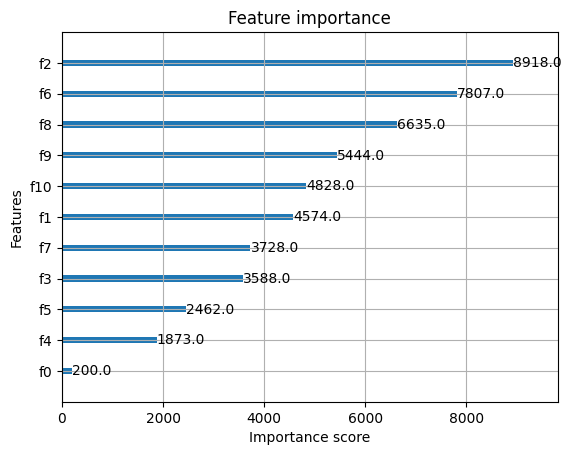

In [ ]:
plot_importance(clf);

In [ ]:
y_pred = clf.predict(X_tests)


probas = clf.predict_proba(X_tests)[:,1]
for pred, true in zip(y_pred[:], y_tests[:]):
    print(f"Predicted: {pred}, Actual: {true}")

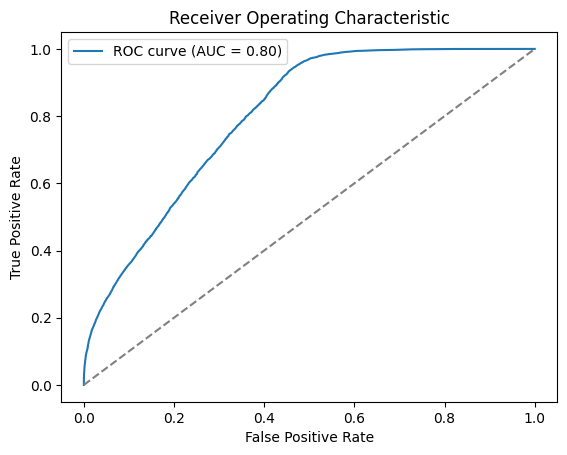

In [24]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_tests, probas)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend()
plt.show()

In [ ]:
# numeric_df = df_feat.select_dtypes(include=[np.number])
#     if df_feat.isnull().values.any() or df_feat.isna().values.any() or np.isinf(numeric_df.values).any():
#         print(f"Mã {ticker} có NaN hoặc inf")

IndentationError: unexpected indent (3527825595.py, line 2)